In this Python notebook we will try to use vision transformer as another method to implement our classification plants & diseases task.
This code is based on the ideas that presented on the paper - "An Image Is Worth 16x16 Words"

part 1 - useful imports and functions:

In [15]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
import random
from tqdm import tqdm
from torchsummary import summary

In [8]:
def divide_to_patches(image, patch_size=16, grid_w=14, grid_h=14):
    image_width, image_height = image.shape[1], image.shape[2]
    num_of_patches = (image_width // patch_size) * (image_height // patch_size)
    patches_list = []
    patches = np.zeros((num_of_patches, 3, patch_size, patch_size))
    for i in range(grid_h):
        for j in range(grid_w):
            patches_list.append(image[0:3, i*patch_size : (i+1)*patch_size, j*patch_size : (j+1)*patch_size])
    for i in range(len(patches_list)):
        patches[i] = patches_list[i]
    return torch.Tensor(patches)

def flatten_patch_to_sequence(patch):
    flattened_tensor = patch.view(196, -1)
    return flattened_tensor

def show_image_patches(patches: torch.Tensor, grid_width=14, grid_height=14):
    num_images = patches.shape[0]
    fig, axes = plt.subplots(grid_width, grid_height, figsize=(10, 10))
    for i in range(num_images):
        part_of_image = patches[i].clamp(0, 1).numpy()
        ax = axes[i // grid_width, i % grid_height]
        ax.imshow(part_of_image.transpose(1, 2, 0)) 
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_sequenced_patch(patches: torch.Tensor, grid_width=14, grid_height=14):
    num_images = patches.shape[0]
    fig, axes = plt.subplots(1, grid_width * grid_height, figsize=(30, 1))
    for i in range(num_images):
        part_of_image = patches[i].clamp(0, 1).numpy()
        ax = axes[i]
        ax.imshow(part_of_image.transpose(1, 2, 0)) 
        ax.axis('off')
    plt.show()

def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([38, 38], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_built():
    print("using MPS")
    device = torch.device("mps")


using MPS


part 2 - loading the dataset:

In [3]:
local_root_dir = 'Dataset/PlantVillage 2'

dataset_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

classes = ["Apple, Scab", "Apple, Black rot", "Apple, Cedar rust", "Apple, Healthy", "Blueberry, Healthy",
           "Cherry, Healthy", "Cherry, Powdery mildew", "Corn, Cercospora spot", "Corn, Common rust",
           "Corn, Healthy", "Corn Northern Leaf Blight", "Grape, Black rot", "Grape, Esca", "Grape, Healthy",
           "Grape, Leaf blight (Isariposis)", "Orange, Haunglongbing", "Peach, Bacterial spot",
           "Peach, Healthy", "Pepper, Bacterial spot", "Pepper, Healthy", "Potato, Early Blight",
           "Potato, Healthy", "Potato, Late Blight", "Raspberry, Healthy", "Soybean, Healthy",
           "Squash, Powdery mildew", "Strawberry, Healthy", "Strawberry, Leaf Scorch", "Tomato, Bacterial spot",
           "Tomato, Early Blight", "Tomato, Healthy", "Tomato, Late Blight", "Tomato, Leaf Mold",
           "Tomato, Septoria leaf spot", "Tomato, Spider mites", "Tomato, Target spot", "Tomato, Moasic virus",
           "Tomato, Yellow leaf curl virus"]

train_set = datasets.ImageFolder(root=local_root_dir + '/train', transform=dataset_transform)
valid_set = datasets.ImageFolder(root=local_root_dir + '/val', transform=dataset_transform)
test_set = datasets.ImageFolder(root=local_root_dir + '/test', transform=dataset_transform)

train_size = len(train_set)
valid_size = len(valid_set)
test_size = len(test_set)


print(f"train dataset has {train_size} samples\nvalidation dataset has {valid_size} samples\ntest dataset has {test_size} samples")


train dataset has 39116 samples
validation dataset has 10861 samples
test dataset has 4328 samples


part 3 - preparing the data for the encoder:

According to the paper it is required to split the input images to patches. We will use the same size as suggested - 16x16 patches.
The images are with size of (224,224), therefore each image will have $\frac{224}{16}$ $\cdot$ $\frac{224}{16}$ = $14$$\cdot$$14$ = $196$ patches.
After we patched the image, we need to make it looks more like a sequence, so we will flatten the tensor (image) to 196$\times$768 tensor, where 196 represents the number of patches and 768 represents the flattened tensor of each patch: $\underbrace{\text{16}}_{\Large\text(1)}$ $\times$ $\underbrace{\text{16}}_{\Large\text(2)}$ $\times$ $\underbrace{\text{3}}_{\Large\text(3)}$
$(1)  \text{Patch width}$
$(2)  \text{Patch height}$
$(3)  \text{Patch channels}$
From here we understand that the embedding dimension would be 768. TODO - make sure this claim

choosing random picture from the train set...
shape of the image divided to patches: torch.Size([196, 3, 16, 16])


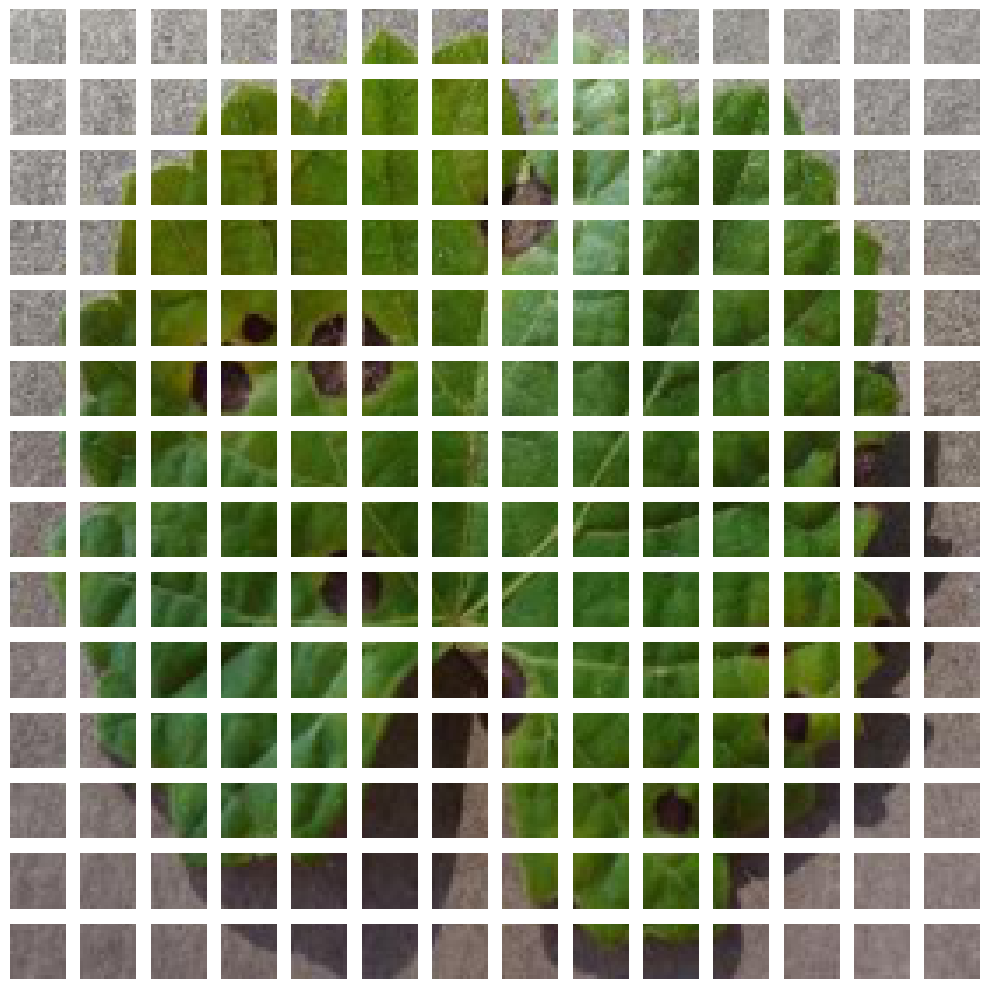

shape of the sequenced patch: torch.Size([196, 768])


In [19]:
print('choosing random picture from the train set...')
random_picture_idx = random.randint(0, len(train_set) - 1)
picture_position = 0
output_patched_image = divide_to_patches(train_set[random_picture_idx][picture_position])
print(f'shape of the image divided to patches: {output_patched_image.shape}')
show_image_patches(output_patched_image)
sequenced_patch = flatten_patch_to_sequence(output_patched_image)
print(f'shape of the sequenced patch: {sequenced_patch.shape}')
show_sequenced_patch(output_patched_image)

part 4 - Linear project each flatten patch before we pass it to the encoder. After the projection we concat each projected flattened patch with its positional embedding.

After explaining the process of the ViT we will use pre-trained model of ViT and use transfer learning for our task - plants classification and their health status

In [20]:
# get the weights of pre-trained model. DEFAULT = IMAGENET1K_V1
ViT_pre_trained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# define ViT pre-trained model with DEFAULT weights.
print(device)
ViT_pre_trained_model = torchvision.models.vit_b_16(weights=ViT_pre_trained_weights).to(device)

# freezing the base params
for param in ViT_pre_trained_model.parameters():
    param.requires_grad = False

# changing the mlp layer to match for the new task - plants classification
ViT_pre_trained_model.heads = nn.Linear(in_features=768, out_features=len(classes), bias=True)

mps


In [4]:
# loading dataset:
ViT_pre_trained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
ViT_transform = ViT_pre_trained_weights.transforms()
new_transform = transforms.Compose([
    transforms.ToTensor(),
    ViT_transform,
    ])


train_set = datasets.ImageFolder(root=local_root_dir + '/train', transform=new_transform)
valid_set = datasets.ImageFolder(root=local_root_dir + '/val', transform=new_transform)
test_set = datasets.ImageFolder(root=local_root_dir + '/test', transform=new_transform)

train_size = len(train_set)
valid_size = len(valid_set)
test_size = len(test_set)

print(f"train dataset has {train_size} samples\nvalidation dataset has {valid_size} samples\ntest dataset has {test_size} samples")

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_size, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

train dataset has 39116 samples
validation dataset has 10861 samples
test dataset has 4328 samples


In [5]:
def train_model_for_test(model, trainloader, epochs, learning_rate, model_loss, model_name_to_save, korina=False):
    print(device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()  # put in training mode, turn on Dropout, BatchNorm uses batch's statistics
        running_loss = 0.0
        epoch_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward pass
            
            loss = criterion(outputs, labels)  # calculate the loss
            
            optimizer.zero_grad()  # zero the parameter gradients
            loss.backward()  # backpropagation
            optimizer.step()  # update parameters

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)
        model_loss.append(running_loss)

        # Calculate training/test set accuracy of the existing model
        train_accuracy, _ = calculate_accuracy(model, trainloader, device)

        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

        # save model
        if epoch % 10 == 0:
            print('==> Saving model ...')
            state = {
                'net': model.state_dict(),
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, f'./checkpoints/{model_name_to_save}.pth')

    print('==> Finished Training ...')
    if not os.path.isdir('checkpoints'):
        os.mkdir('checkpoints')
    torch.save(state, f'./checkpoints/{model_name_to_save}.pth')
    #return model

In [6]:
def feature_extract_or_fine_tuning(model, feature_extract=True):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = [] # override the initial list definition above
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        print("here")
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

In [24]:
model_ft = ViT_pre_trained_model.to(device)
feature_extract = True
feature_extract_or_fine_tuning(model_ft)

Params to learn:
	 heads.weight
	 heads.bias


In [25]:
model_loss_fine_tune_mlp = []
train_model_for_test(model_ft, train_dataloader, 10, 0.001, model_loss_fine_tune_mlp, "ViT_pre_trained", False)

mps


 10%|█         | 1/10 [22:57<3:26:33, 1377.06s/it]

Epoch: 1 | Loss: 0.3437 | Training accuracy: 97.681% | Epoch Time: 1377.06 secs


 20%|██        | 2/10 [45:51<3:03:23, 1375.38s/it]

Epoch: 2 | Loss: 0.0878 | Training accuracy: 98.619% | Epoch Time: 1374.19 secs


 30%|███       | 3/10 [1:08:45<2:40:22, 1374.67s/it]

Epoch: 3 | Loss: 0.0570 | Training accuracy: 99.031% | Epoch Time: 1373.82 secs


 40%|████      | 4/10 [1:31:40<2:17:29, 1374.98s/it]

Epoch: 4 | Loss: 0.0428 | Training accuracy: 99.305% | Epoch Time: 1375.44 secs


 50%|█████     | 5/10 [1:54:36<1:54:36, 1375.28s/it]

Epoch: 5 | Loss: 0.0337 | Training accuracy: 99.478% | Epoch Time: 1375.82 secs


 60%|██████    | 6/10 [2:17:31<1:31:41, 1375.26s/it]

Epoch: 6 | Loss: 0.0270 | Training accuracy: 99.634% | Epoch Time: 1375.20 secs


 70%|███████   | 7/10 [2:40:26<1:08:45, 1375.15s/it]

Epoch: 7 | Loss: 0.0222 | Training accuracy: 99.680% | Epoch Time: 1374.91 secs


 80%|████████  | 8/10 [3:03:22<45:50, 1375.31s/it]  

Epoch: 8 | Loss: 0.0189 | Training accuracy: 99.732% | Epoch Time: 1375.64 secs


 90%|█████████ | 9/10 [3:25:36<22:42, 1362.58s/it]

Epoch: 9 | Loss: 0.0160 | Training accuracy: 99.714% | Epoch Time: 1334.58 secs
Epoch: 10 | Loss: 0.0141 | Training accuracy: 99.826% | Epoch Time: 1334.11 secs
==> Saving model ...


100%|██████████| 10/10 [3:47:51<00:00, 1367.13s/it]

==> Finished Training ...


In [26]:
test_accuracy, _ = calculate_accuracy(ViT_pre_trained_model, test_dataloader, device)
print(f"test accuracy:{test_accuracy}")

test accuracy:98.38262476894639


In [9]:
ViT_pre_trained_model_fine_tuning = torchvision.models.vit_b_16(weights=ViT_pre_trained_weights).to(device)
for param in ViT_pre_trained_model_fine_tuning.parameters():
    param.requires_grad = True

# changing the mlp layer to match for the new task - plants classification
ViT_pre_trained_model_fine_tuning.heads = nn.Linear(in_features=768, out_features=len(classes), bias=True)

# freezing the base params
feature_extract_or_fine_tuning(ViT_pre_trained_model_fine_tuning, False)
model_loss_fine_tuned = []

Params to learn:
here
	 class_token
	 conv_proj.weight
	 conv_proj.bias
	 encoder.pos_embedding
	 encoder.layers.encoder_layer_0.ln_1.weight
	 encoder.layers.encoder_layer_0.ln_1.bias
	 encoder.layers.encoder_layer_0.self_attention.in_proj_weight
	 encoder.layers.encoder_layer_0.self_attention.in_proj_bias
	 encoder.layers.encoder_layer_0.self_attention.out_proj.weight
	 encoder.layers.encoder_layer_0.self_attention.out_proj.bias
	 encoder.layers.encoder_layer_0.ln_2.weight
	 encoder.layers.encoder_layer_0.ln_2.bias
	 encoder.layers.encoder_layer_0.mlp.0.weight
	 encoder.layers.encoder_layer_0.mlp.0.bias
	 encoder.layers.encoder_layer_0.mlp.3.weight
	 encoder.layers.encoder_layer_0.mlp.3.bias
	 encoder.layers.encoder_layer_1.ln_1.weight
	 encoder.layers.encoder_layer_1.ln_1.bias
	 encoder.layers.encoder_layer_1.self_attention.in_proj_weight
	 encoder.layers.encoder_layer_1.self_attention.in_proj_bias
	 encoder.layers.encoder_layer_1.self_attention.out_proj.weight
	 encoder.layers.encod

In [10]:
train_model_for_test(ViT_pre_trained_model_fine_tuning, train_dataloader, 8, 0.001, model_loss_fine_tuned, "ViT_pre_trained_fine_tuned", False)

mps


 12%|█▎        | 1/8 [42:40<4:58:46, 2560.97s/it]

Epoch: 1 | Loss: 1.6595 | Training accuracy: 72.763% | Epoch Time: 2560.97 secs


 25%|██▌       | 2/8 [1:25:41<4:17:15, 2572.60s/it]

Epoch: 2 | Loss: 0.7249 | Training accuracy: 84.459% | Epoch Time: 2580.72 secs


 38%|███▊      | 3/8 [2:08:43<3:34:43, 2576.80s/it]

Epoch: 3 | Loss: 0.4942 | Training accuracy: 87.284% | Epoch Time: 2581.78 secs


 50%|█████     | 4/8 [2:51:44<2:51:53, 2578.39s/it]

Epoch: 4 | Loss: 0.3976 | Training accuracy: 90.853% | Epoch Time: 2580.82 secs


 62%|██████▎   | 5/8 [3:34:49<2:09:01, 2580.66s/it]

Epoch: 5 | Loss: 0.3276 | Training accuracy: 92.108% | Epoch Time: 2584.69 secs


 75%|███████▌  | 6/8 [4:17:52<1:26:03, 2581.54s/it]

Epoch: 6 | Loss: 0.2802 | Training accuracy: 90.820% | Epoch Time: 2583.23 secs


 88%|████████▊ | 7/8 [5:00:52<43:01, 2581.15s/it]  

Epoch: 7 | Loss: 0.2381 | Training accuracy: 94.307% | Epoch Time: 2580.34 secs


100%|██████████| 8/8 [5:43:18<00:00, 2574.76s/it]

Epoch: 8 | Loss: 0.2087 | Training accuracy: 93.872% | Epoch Time: 2545.43 secs
==> Finished Training ...


UnboundLocalError: local variable 'state' referenced before assignment

In [11]:
test_accuracy, _ = calculate_accuracy(ViT_pre_trained_model_fine_tuning, test_dataloader, device)
print(f"test accuracy:{test_accuracy}")

test accuracy:91.47412199630314
